In [1]:
import keras
import pickle
import pandas as pd
import numpy as np
from keras.models import Model,load_model
from keras.layers import Input,Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.optimizers import Adam
from sklearn import datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import matplotlib.pyplot as plt

RANDOM_SEED=37117
np.random.seed(RANDOM_SEED)

X: [5.1 3.5 1.4 0.2]
pca_transformed:  [-0.63070293  0.10757791 -0.0187191  -0.00730695]


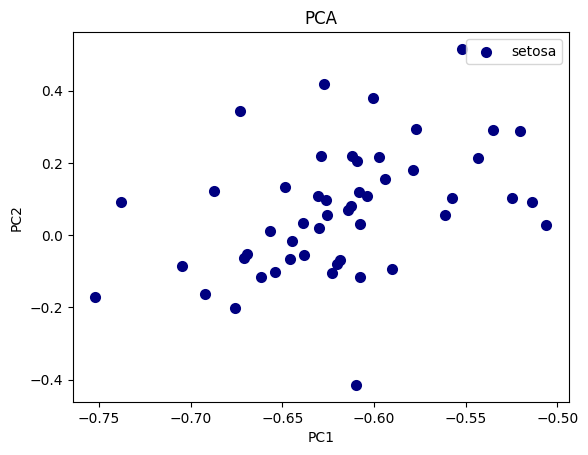

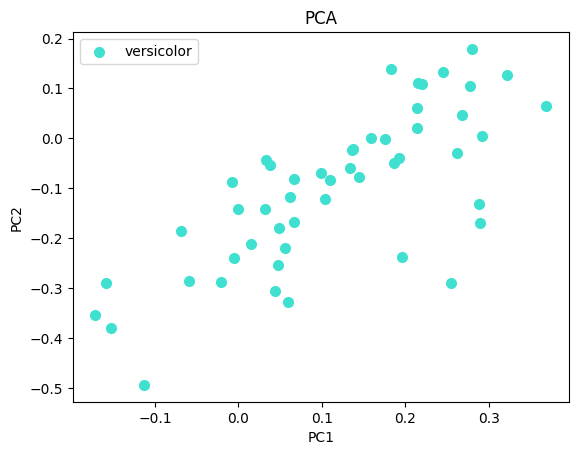

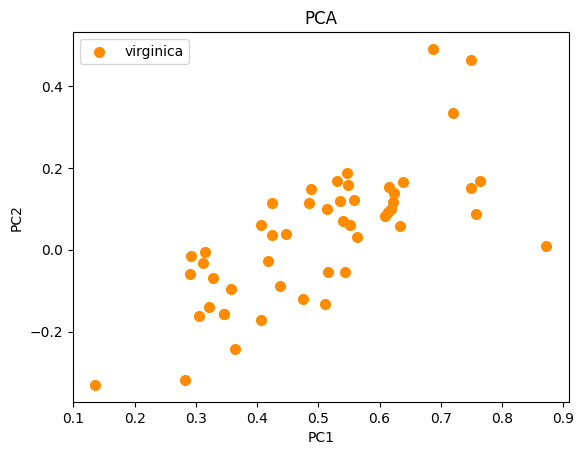

In [2]:
iris=datasets.load_iris()

X=iris.data
y=iris.target
print("X:",X[0])
target_names=iris.target_names

scaler=MinMaxScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)


def plot3clusters(X,title,vtitle):
 plt.figure()
 colors=['navy','turquoise','darkorange']
 lw=2
 for color,i,target_name in zip(colors,[0,1,2],target_names):
  plt.scatter(X[y==i,0],X[y==i,1],color=color,alpha=1.,lw=lw,label=target_name)
  plt.legend(loc='best',shadow=False,scatterpoints=1)
  plt.title(title)
  plt.xlabel(vtitle+"1")
  plt.ylabel(vtitle+"2")
  plt.show()

pca=decomposition.PCA()
pca_transformed=pca.fit_transform(X_scaled)
print("pca_transformed: ",pca_transformed[0])
plot3clusters(pca_transformed[:,:2],'PCA','PC')

In [3]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim=X_scaled.shape[1]
encoding_dim=2
input_img=Input(shape=(input_dim,))
encoded=Dense(encoding_dim,activation='linear')(input_img)
decoded=Dense(input_dim,activation='linear')(encoded)
autoencoder=Model(input_img,decoded)
autoencoder.compile(optimizer='adam',loss='mse')
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 2)                 10        
                                                                 
 dense_1 (Dense)             (None, 4)                 12        
                                                                 
Total params: 22 (88.00 Byte)
Trainable params: 22 (88.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


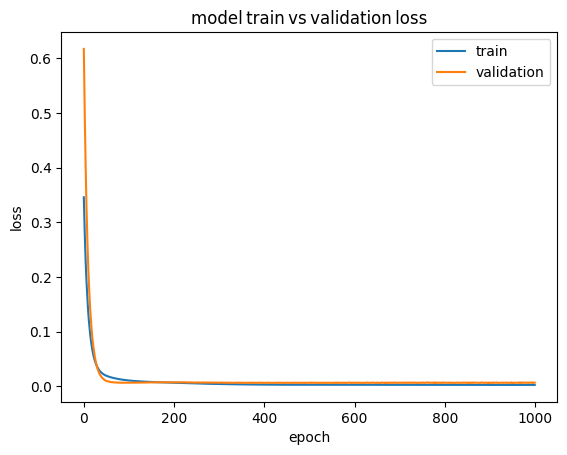

In [4]:
history=autoencoder.fit(X_scaled,X_scaled,epochs=1000,batch_size=16,shuffle=True,validation_split=0.1,verbose=0)

#plot our loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='best')
plt.show()

5/5 [==============================] - 0s 2ms/step


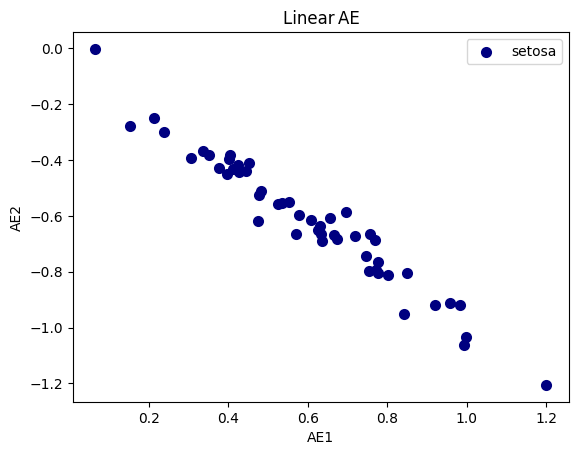

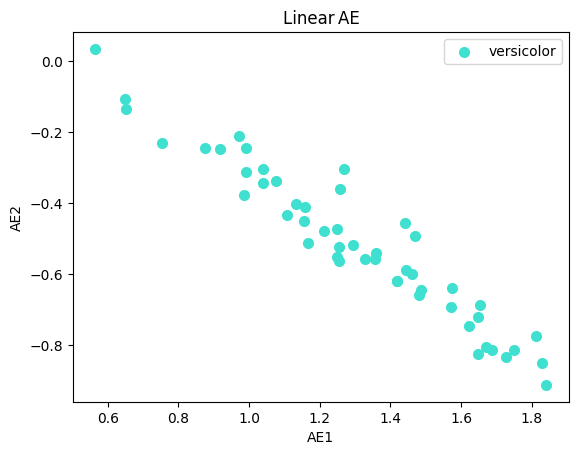

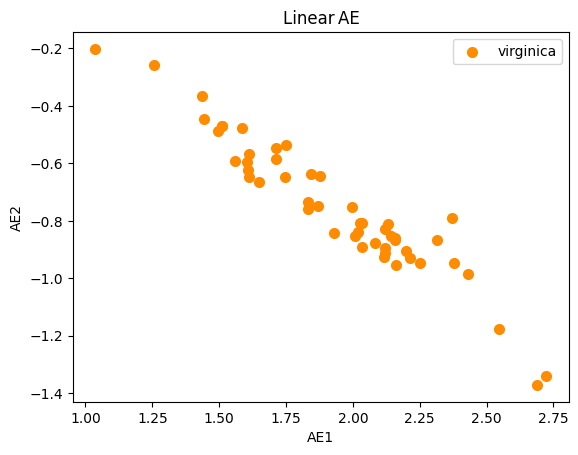

In [5]:
# use our encoded layer to encode the training input
encoder=Model(input_img,encoded)
encoded_input=Input(shape=(encoding_dim,))
decoder_layer=autoencoder.layers[-1]
decoder=Model(encoded_input,decoder_layer(encoded_input))
encoded_data=encoder.predict(X_scaled)
plot3clusters(encoded_data[:,:2],'Linear AE','AE')

In [6]:
labels_true=y
titles=['PCA','Linear AE']

for n_clusters_ in [2]:
 estimators=[('PCA',KMeans(n_clusters=n_clusters_),pca_transformed),('AE linear',KMeans(n_clusters=n_clusters_),encoded_data)]
 print(type(y))
for name,est,data in estimators:
 X=data
 est.fit(X)
 labels=est.labels_
 print(name,':')
 print(labels[:])
 print('Estimated number of clusters: %d'%n_clusters_)
 print("Homogeneity: %0.3f"%metrics.homogeneity_score(labels_true,labels))
 print("Completeness: %0.3f"%metrics.completeness_score(labels_true,labels))
 print("V-measure: %0.3f"%metrics.v_measure_score(labels_true,labels))
 print("Adjusted Rand Index: %0.3f"%metrics.adjusted_rand_score(labels_true,labels))
 print("Adjusted Mutual Information: %0.3f"%metrics.adjusted_mutual_info_score(labels_true,labels))
 print("Silhouette Coefficient: %0.3f"%metrics.silhouette_score(X,labels))

print('----------------------------------------------------------------------------------')

<class 'numpy.ndarray'>
PCA :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
Estimated number of clusters: 2
Homogeneity: 0.579
Completeness: 1.000
V-measure: 0.734
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.732
Silhouette Coefficient: 0.630
AE linear :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1
 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
Estimated number of clusters: 2
Homogeneity: 0.340
Completeness: 0.539
V-measure: 0.417
Adjusted Rand Index: 0.387
Adjusted Mutual Information: 0.412
Silhouette Coeff

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 10        
                                                                 
 dense_3 (Dense)             (None, 4)                 12        
                                                                 
Total params: 22 (88.00 Byte)
Trainable params: 22 (88.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


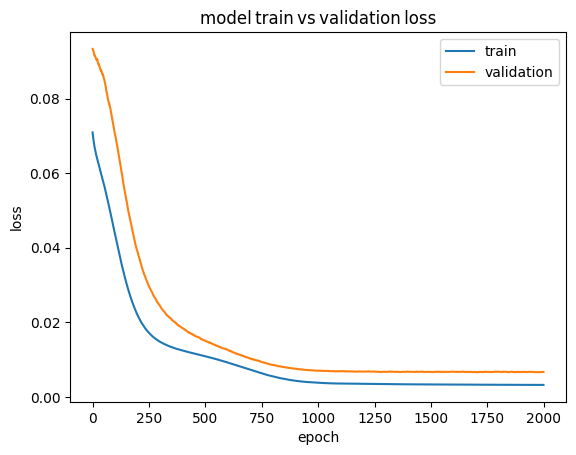

5/5 [==============================] - 0s 2ms/step


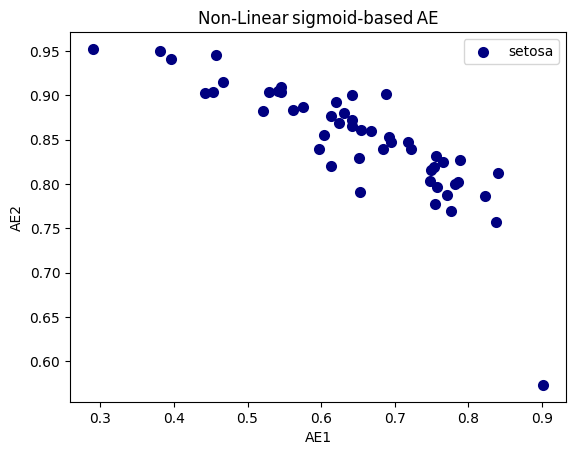

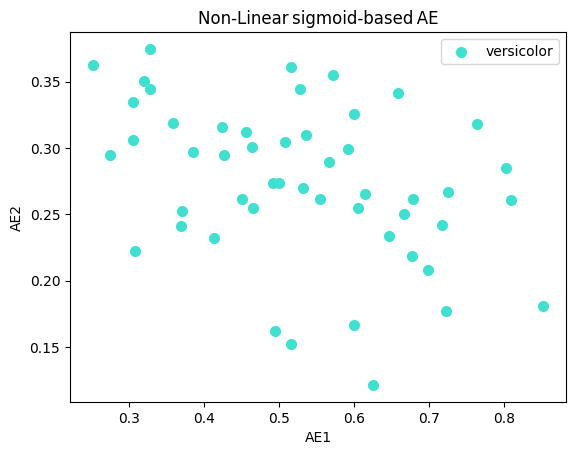

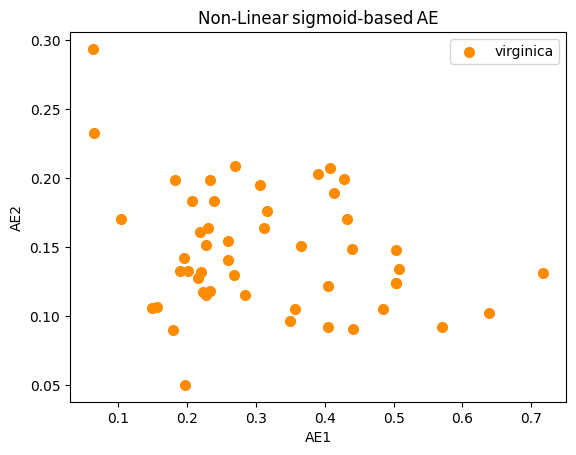

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
 dense_5 (Dense)             (None, 4)                 12        
                                                                 
Total params: 22 (88.00 Byte)
Trainable params: 22 (88.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


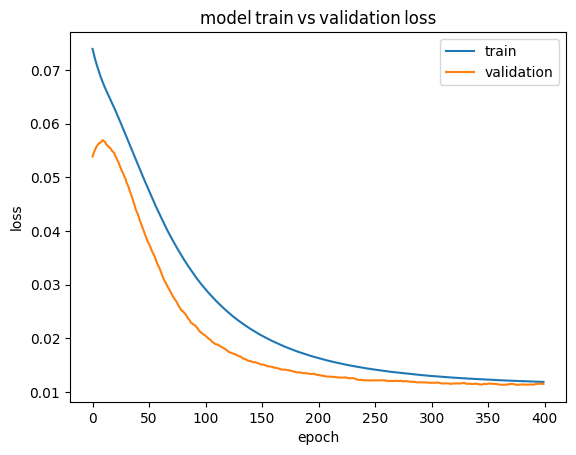

5/5 [==============================] - 0s 3ms/step


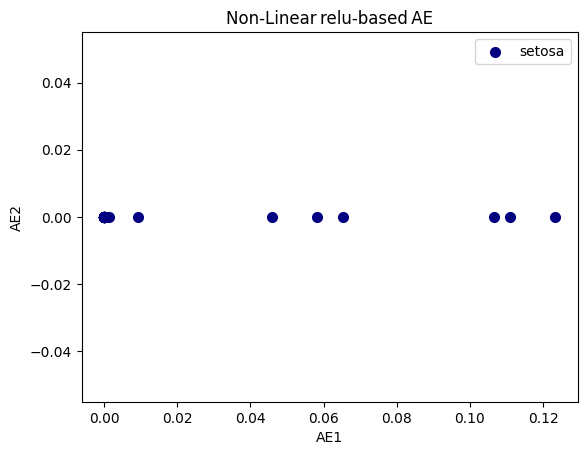

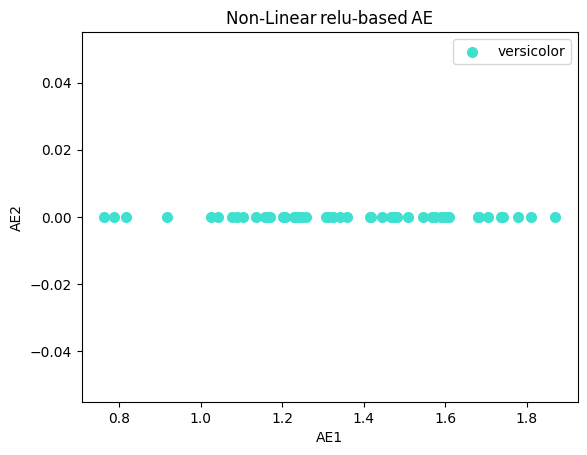

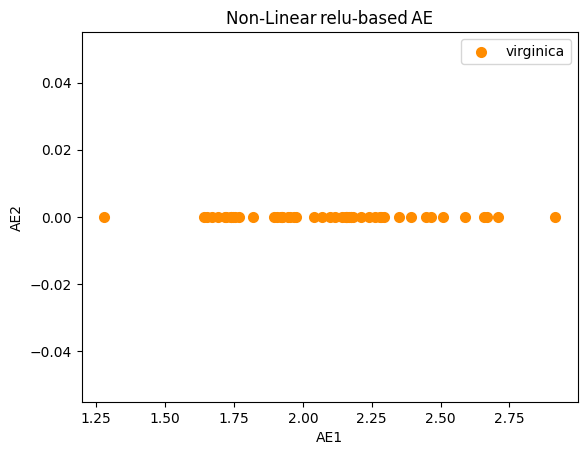

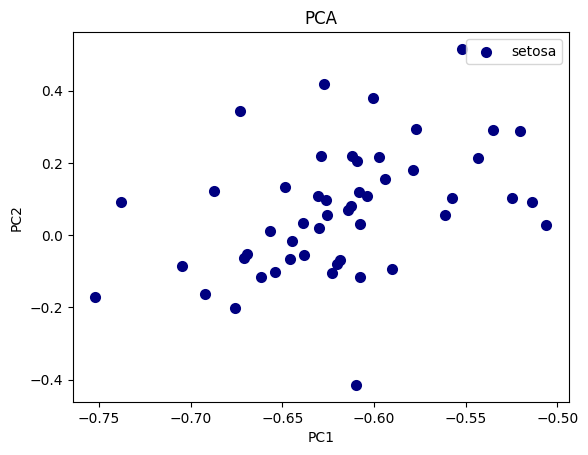

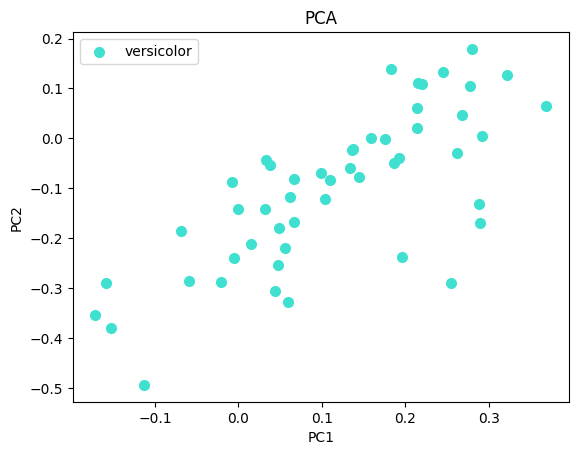

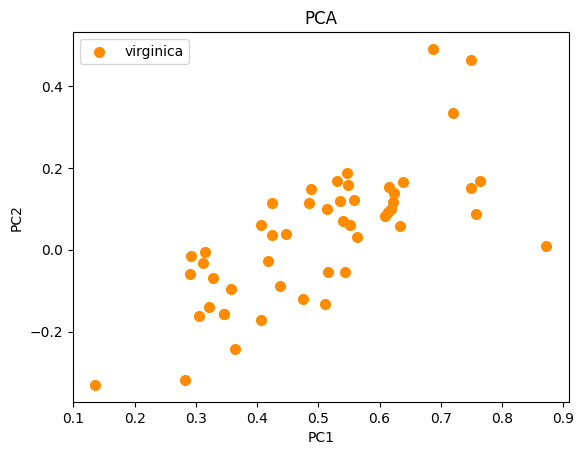

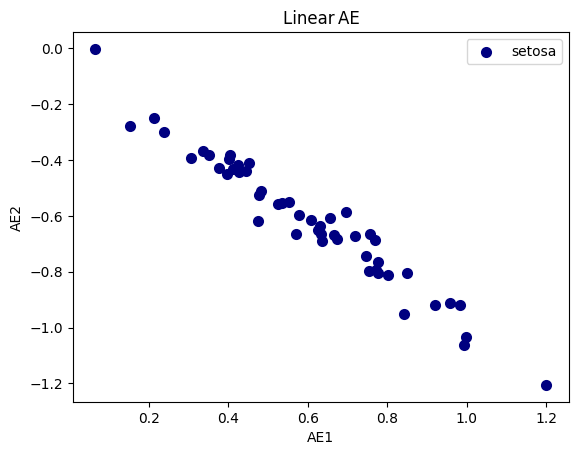

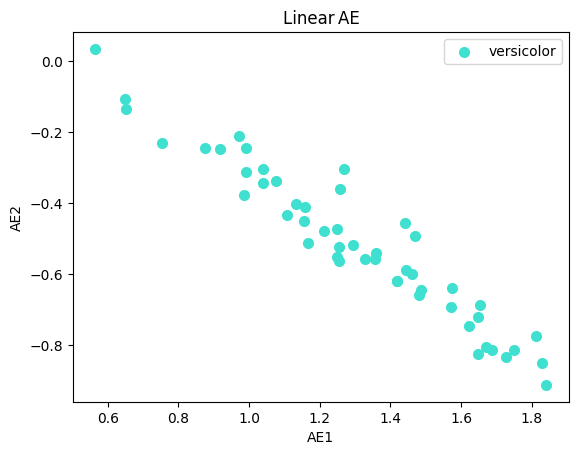

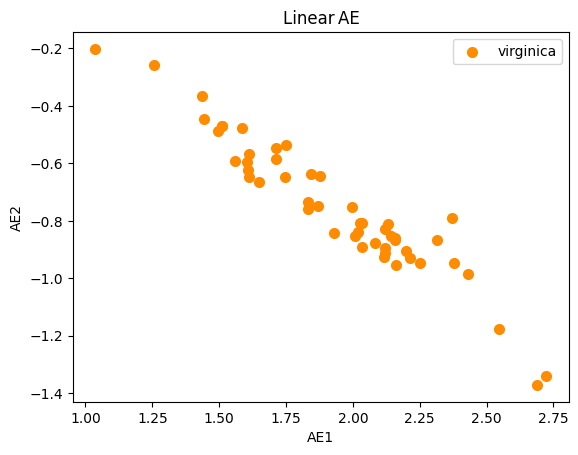

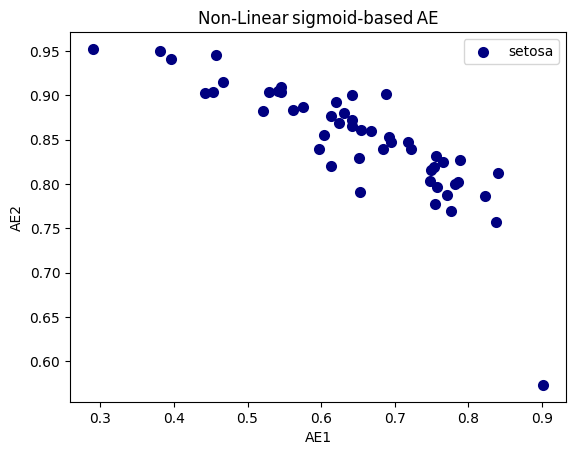

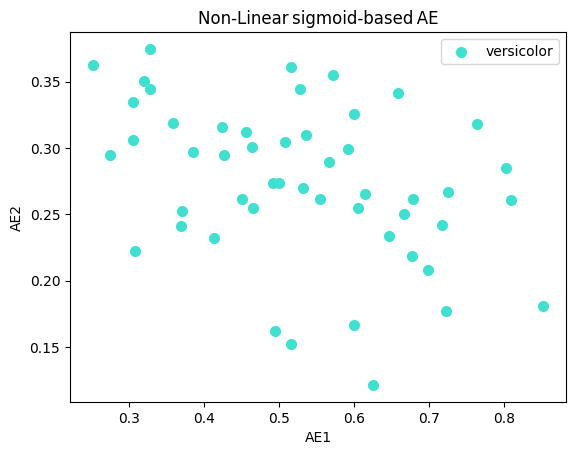

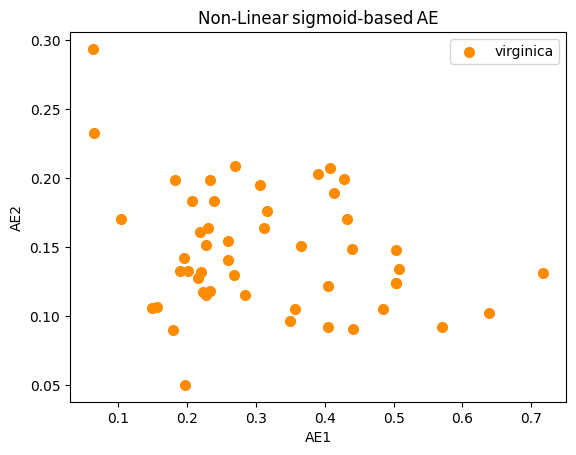

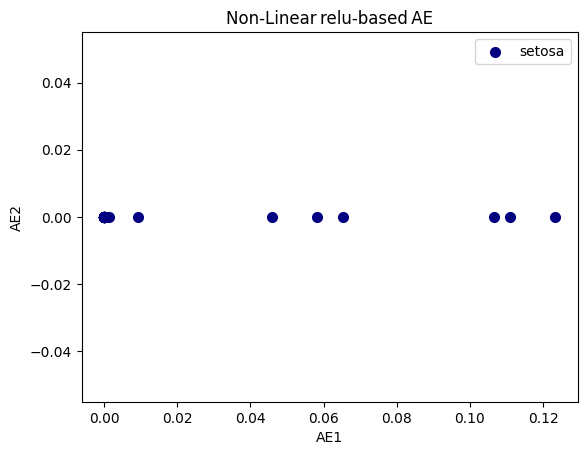

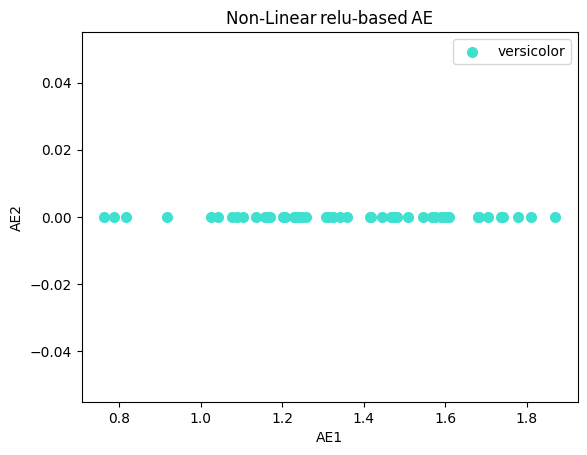

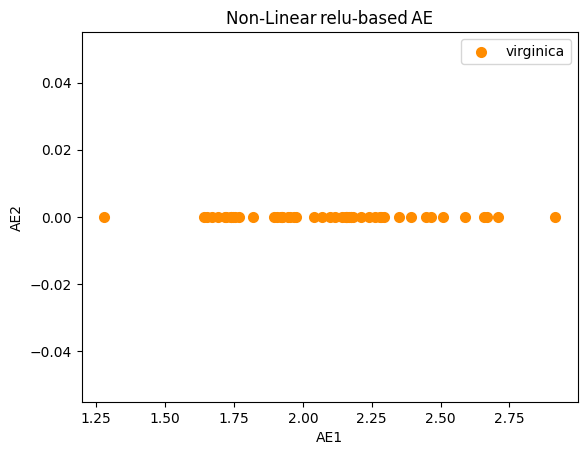

In [7]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API

input_dim2=X_scaled.shape[1]
encoding_dim2=2
input_img2=Input(shape=(input_dim2,))
encoded2=Dense(encoding_dim2,activation='sigmoid')(input_img2)
decoded2=Dense(input_dim2,activation='sigmoid')(encoded2)
autoencoder2=Model(input_img2,decoded2)
autoencoder2.compile(optimizer='adam',loss='mse')
print(autoencoder2.summary())
history2=autoencoder2.fit(X_scaled,X_scaled,epochs=2000,batch_size=16,shuffle=True,validation_split=0.1,verbose=0)

#plot our loss

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='best')
plt.show()

# use our encoded layer to encode the training input
encoder2=Model(input_img2,encoded2)
encoded_input2=Input(shape=(encoding_dim2,))
decoder_layer2=autoencoder2.layers[-1]
decoder2=Model(encoded_input2,decoder_layer2(encoded_input2))
encoded_data2=encoder2.predict(X_scaled)

plot3clusters(encoded_data2[:,:2],'Non-Linear sigmoid-based AE','AE')

#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim3=X_scaled.shape[1]
encoding_dim3=2
input_img3=Input(shape=(input_dim3,))
encoded3=Dense(encoding_dim3,activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_img3)
decoded3=Dense(input_dim3,activation='sigmoid')(encoded3)
autoencoder3=Model(input_img3,decoded3)

autoencoder3.compile(optimizer='adam',loss='mse')
print(autoencoder3.summary())

history3=autoencoder3.fit(X_scaled,X_scaled,epochs=400,batch_size=16,shuffle=True,validation_split=0.1,verbose=0)
#plot our loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train','validation'],loc='best')

plt.show()
# use our encoded layer to encode the training input
encoder3=Model(input_img3,encoded3)
encoded_input3=Input(shape=(encoding_dim3,))
decoder_layer3=autoencoder3.layers[-1]
decoder3=Model(encoded_input3,decoder_layer3(encoded_input3))
encoded_data3=encoder3.predict(X_scaled)
plot3clusters(encoded_data3[:,:2],'Non-Linear relu-based AE','AE')
plot3clusters(pca_transformed[:,:2],'PCA','PC')
plot3clusters(encoded_data[:,:2],'Linear AE','AE')
plot3clusters(encoded_data2[:,:2],'Non-Linear sigmoid-based AE','AE')
plot3clusters(encoded_data3[:,:2],'Non-Linear relu-based AE','AE')